In [26]:
# Importar as bibliotecas necessárias
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import concurrent.futures

In [27]:
# Defina os caminhos
SOURCE_DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data"
TARGET_DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data_256" # Nova pasta
TARGET_SIZE = (256, 256)

# print(f"Criando nova estrutura de pastas em: {TARGET_DATA_DIR}")
# os.makedirs(os.path.join(TARGET_DATA_DIR, "train/images"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "train/masks"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "validation/images"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "validation/masks"), exist_ok=True)

# def process_single_image(args):
#     filename, source_img_folder, source_mask_folder, target_img_folder, target_mask_folder = args
#     try:
#         with Image.open(os.path.join(source_img_folder, filename)) as img:
#             img_resized = img.resize(TARGET_SIZE, Image.LANCZOS)
#             img_resized.save(os.path.join(target_img_folder, filename))

#         mask_filename = filename.replace(".jpg", ".png")
#         mask_path = os.path.join(source_mask_folder, mask_filename)
#         if not os.path.exists(mask_path):
#             mask_path = os.path.join(source_mask_folder, filename) # Tenta o mesmo nome

#         with Image.open(mask_path) as mask:
#             mask_resized = mask.resize(TARGET_SIZE, Image.NEAREST)
#             mask_resized.save(os.path.join(target_mask_folder, mask_filename))
#     except Exception as e:
#         print(f"Erro ao processar {filename}: {e}")

# def preprocess_dataset(subset):
#     print(f"\nProcessando o conjunto de dados: {subset}")
#     source_img_folder = os.path.join(SOURCE_DATA_DIR, f"{subset}/images")
#     source_mask_folder = os.path.join(SOURCE_DATA_DIR, f"{subset}/masks")
#     target_img_folder = os.path.join(TARGET_DATA_DIR, f"{subset}/images")
#     target_mask_folder = os.path.join(TARGET_DATA_DIR, f"{subset}/masks")
#     image_files = os.listdir(source_img_folder)

#     args_list = [
#         (filename, source_img_folder, source_mask_folder, target_img_folder, target_mask_folder)
#         for filename in image_files
#     ]

#     with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
#         list(tqdm(executor.map(process_single_image, args_list), total=len(args_list), desc=f"Redimensionando {subset} images"))

# # Executar para treino e validação
# preprocess_dataset("train")
# preprocess_dataset("validation")

# print("\nPré-processamento concluído!")

In [ ]:
# --- CONFIGURAÇÃO E HIPERPARÂMETROS ---

# 1. Configurações do Ambiente e Caminhos
# DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data"
DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data_256"
MODEL_SAVE_PATH = "./tomato_unet_best.pth"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando o dispositivo: {DEVICE}")

# 2. Hiperparâmetros do Modelo e Treinamento
# a) Analise os hiperparâmetros usados
#    - LEARNING_RATE: Taxa de aprendizado. Controla o tamanho do passo na otimização.
#      Valores comuns: 1e-3, 1e-4, 1e-5.
#    - BATCH_SIZE: Número de imagens por lote. Depende da memória da sua GPU.
#      Valores comuns: 4, 8, 16, 32.
#    - NUM_EPOCHS: Número de vezes que o modelo verá todo o dataset de treino.
#    - OPTIMIZER: Algoritmo de otimização. 'Adam' é um padrão robusto. 'SGD' com momentum
#      também é uma opção clássica.
#    - LOSS_FUNCTION: Como medimos o erro. 'BCEWithLogitsLoss' é padrão para
#      classificação binária. 'DiceLoss' é excelente para segmentação e lida
#      bem com desbalanceamento de classes. Uma combinação dos dois é ainda melhor.

config = {
    "LEARNING_RATE": 1e-4,
    "BATCH_SIZE": 4,
    "NUM_EPOCHS": 50,
    "IMAGE_HEIGHT": 256, # Redimensionar imagens para um tamanho fixo
    "IMAGE_WIDTH": 256,
    "OPTIMIZER": "Adam", # Opções: "Adam", "SGD" - investigar otimizar AUTO
    "LOSS_FUNCTION": "DiceBCE" # Opções: "BCE", "Dice", "DiceBCE"
}

Usando o dispositivo: cuda


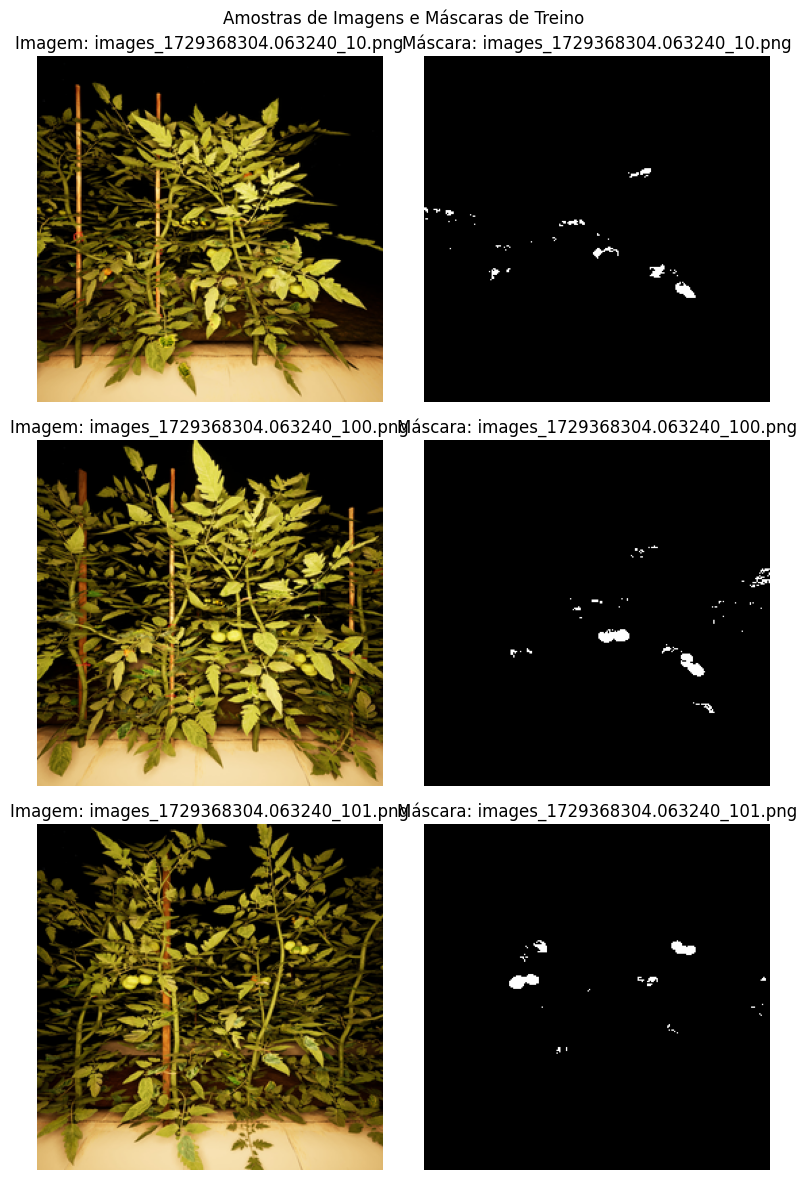

Analisando a proporção de pixels de 'tomate' nas máscaras de treino...


100%|██████████| 100/100 [00:00<00:00, 3038.54it/s]


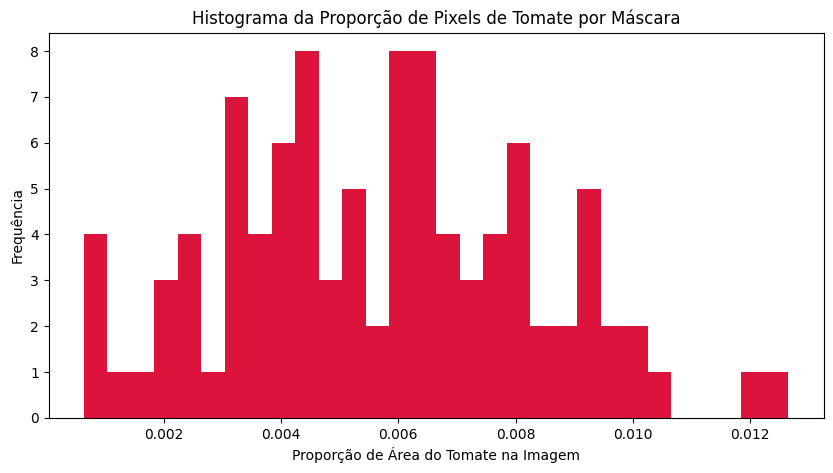

Análise concluída. Média da proporção (em imagens com tomates): 0.0057


In [29]:
# a) Pré-processamento, análise estatística dos dados, visualização

# Vamos visualizar algumas imagens e máscaras para entender os dados
train_img_dir = os.path.join(DATA_DIR, "train/images")
train_mask_dir = os.path.join(DATA_DIR, "train/masks")

# Pegar uma lista de imagens (assumindo que os nomes correspondem)
sample_images = os.listdir(train_img_dir)[:3]

fig, axs = plt.subplots(len(sample_images), 2, figsize=(8, 12))
fig.suptitle('Amostras de Imagens e Máscaras de Treino')

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(train_img_dir, img_name)
    # Assumindo que a máscara tem o mesmo nome, mas talvez extensão diferente
    # Tente .png ou .jpg se necessário
    mask_path = os.path.join(train_mask_dir, img_name.replace('.jpg', '.png'))
    if not os.path.exists(mask_path):
        mask_path = os.path.join(train_mask_dir, img_name)


    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L") # Converter para tons de cinza

    axs[i, 0].imshow(image)
    axs[i, 0].set_title(f"Imagem: {img_name}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].set_title(f"Máscara: {os.path.basename(mask_path)}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Análise Estatística Simples: Proporção de pixels de tomate
print("Analisando a proporção de pixels de 'tomate' nas máscaras de treino...")
mask_files = os.listdir(train_mask_dir)
tomato_proportions = []
for mask_file in tqdm(mask_files[:100]): # Analisar as primeiras 100 para ser rápido
    mask_path = os.path.join(train_mask_dir, mask_file)
    mask_np = np.array(Image.open(mask_path).convert("L"))
    proportion = np.sum(mask_np > 128) / (mask_np.shape[0] * mask_np.shape[1])
    if proportion > 0: # Apenas se houver tomate
        tomato_proportions.append(proportion)

plt.figure(figsize=(10, 5))
plt.hist(tomato_proportions, bins=30, color='crimson')
plt.title('Histograma da Proporção de Pixels de Tomate por Máscara')
plt.xlabel('Proporção de Área do Tomate na Imagem')
plt.ylabel('Frequência')
plt.show()
print(f"Análise concluída. Média da proporção (em imagens com tomates): {np.mean(tomato_proportions):.4f}")

In [ ]:
# Classe customizada para carregar os dados
class TomatoDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.image_dir, img_name)

        # Tratar extensões diferentes entre imagem e máscara
        mask_name = img_name
        possible_mask_exts = ['.png', '.jpg', '.jpeg']
        for ext in possible_mask_exts:
            if mask_name.endswith(ext):
                base_name = mask_name[:-len(ext)]
                break
        else:
            base_name = mask_name

        mask_path = None
        for ext in possible_mask_exts:
            potential_path = os.path.join(self.mask_dir, base_name + ext)
            if os.path.exists(potential_path):
                mask_path = potential_path
                break

        if mask_path is None:
            # Tenta com o mesmo nome exato se falhar
             mask_path = os.path.join(self.mask_dir, img_name)
             if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Não foi possível encontrar a máscara para a imagem {img_name}")


        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

        # Normalizar máscara para 0.0-1.0
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

# Definir transformações (redimensionamento e conversão para tensor)
# Para data augmentation, pode-se usar a biblioteca Albumentations
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# Por simplicidade, usaremos torchvision transforms
NUM_WORKERS = 0 # <<<< COMECE COM ESTE VALOR

# --- Transformações ---
# Como você já pré-processou, não precisamos mais do Resize
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # o ideal é normalizar entre media e desvio padrão, talvez esses nao sejam os parametros ideais, investigar
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
])


class CustomTomatoDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_transform, mask_transform):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        
        # Pega a lista de imagens e cria uma referência para as máscaras
        self.image_files = sorted(os.listdir(image_dir))
        
        # Verificação inicial: Checa se pelo menos a primeira máscara existe
        if len(self.image_files) > 0:
            self._verify_path(0)

    def __len__(self):
        return len(self.image_files)

    def _verify_path(self, index):
        """Função interna para encontrar o caminho correto da máscara."""
        img_name = self.image_files[index]
        base_name, _ = os.path.splitext(img_name)
        
        # Tenta as extensões mais comuns para máscaras
        possible_mask_names = [f"{base_name}.png", f"{base_name}.jpg", f"{base_name}.jpeg"]
        
        for mask_name in possible_mask_names:
            mask_path = os.path.join(self.mask_dir, mask_name)
            if os.path.exists(mask_path):
                return mask_path
        
        # Se não encontrar, levanta um erro claro
        raise FileNotFoundError(f"Não foi possível encontrar a máscara para a imagem '{img_name}'. "
                              f"Procurado por {possible_mask_names} na pasta {self.mask_dir}")

    def __getitem__(self, index):
        try:
            # Caminho da imagem
            img_path = os.path.join(self.image_dir, self.image_files[index])
            
            # Caminho da máscara (verificado pela função interna)
            mask_path = self._verify_path(index)
            
            # Carregar imagem e máscara
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")

            # Aplicar transformações
            image = self.img_transform(image)
            mask = self.mask_transform(mask)
            
            # Binarizar a máscara para garantir 0s e 1s
            mask = (mask > 0.5).float()
            
            return image, mask

        except Exception as e:
            print(f"Erro ao carregar o item no índice {index}, arquivo: {self.image_files[index]}")
            # Retornar o erro para que o DataLoader possa lidar com ele (ou pular o item)
            raise e


# Criar Datasets
try:
    # ATENÇÃO: Verifique se o DATA_DIR está apontando para a pasta pré-processada (ex: .../processed_data_256)
    train_ds = CustomTomatoDataset(
        image_dir=os.path.join(DATA_DIR, "train/images"),
        mask_dir=os.path.join(DATA_DIR, "train/masks"),
        img_transform=data_transform,
        mask_transform=mask_transform
    )

    val_ds = CustomTomatoDataset(
        image_dir=os.path.join(DATA_DIR, "validation/images"),
        mask_dir=os.path.join(DATA_DIR, "validation/masks"),
        img_transform=data_transform,
        mask_transform=mask_transform
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=config["BATCH_SIZE"],
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=config["BATCH_SIZE"],
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    print(f"Dataset de treino: {len(train_ds)} amostras.")
    print(f"Dataset de validação: {len(val_ds)} amostras.")
    print(f"DataLoader usando {NUM_WORKERS} workers.")

except Exception as e:
    print(f"Ocorreu um erro ao criar os datasets: {e}")

print(f"Dataset de treino: {len(train_ds)} amostras.")
print(f"Dataset de validação: {len(val_ds)} amostras.")

Dataset de treino: 17138 amostras.
Dataset de validação: 4229 amostras.
DataLoader usando 0 workers.
Dataset de treino: 17138 amostras.
Dataset de validação: 4229 amostras.


In [31]:
# Bloco de convolução dupla usado na U-Net
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

# Implementação da U-Net
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder (Down path)
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Decoder (Up path)
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = transforms.functional.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Teste rápido para ver se a arquitetura está correta
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
x = torch.randn(2, 3, config["IMAGE_HEIGHT"], config["IMAGE_WIDTH"]).to(DEVICE)
preds = model(x)
assert preds.shape == (2, 1, config["IMAGE_HEIGHT"], config["IMAGE_WIDTH"])
print("Arquitetura U-Net carregada com sucesso!")

Arquitetura U-Net carregada com sucesso!


In [32]:
# Métrica 1: Dice Coefficient / F1 Score
# Essencial para artigos de segmentação
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs) # Aplicar sigmoid para ter probabilidades

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

# Métrica 2: Intersection over Union (IoU) / Jaccard Index
# Também essencial
def check_accuracy_and_get_metrics(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    iou_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1) if len(y.shape) == 3 else y.to(device)

            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)

            # Calcular Dice e IoU por lote e somar
            intersection = (preds * y).sum()
            union = (preds + y).sum() - intersection
            dice_score += (2. * intersection) / ((preds + y).sum() + 1e-8)
            iou_score += intersection / (union + 1e-8)


    accuracy = num_correct/num_pixels*100
    avg_dice = dice_score/len(loader)
    avg_iou = iou_score/len(loader)

    print(f"Acurácia de pixels: {accuracy:.2f}%")
    print(f"Dice Score (Média): {avg_dice:.4f}")
    print(f"IoU/Jaccard (Média): {avg_iou:.4f}")

    model.train()
    return avg_iou, avg_dice

# Escolher a função de perda com base na configuração
if config["LOSS_FUNCTION"] == "BCE":
    loss_fn = nn.BCEWithLogitsLoss()
elif config["LOSS_FUNCTION"] == "Dice":
    loss_fn = DiceLoss()
elif config["LOSS_FUNCTION"] == "DiceBCE":
    class DiceBCELoss(nn.Module):
        def __init__(self, weight=None, size_average=True):
            super(DiceBCELoss, self).__init__()
        def forward(self, inputs, targets, smooth=1):
            inputs_sig = torch.sigmoid(inputs)
            inputs_flat = inputs_sig.view(-1)
            targets_flat = targets.view(-1)
            intersection = (inputs_flat * targets_flat).sum()
            dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
            bce = nn.BCEWithLogitsLoss()(inputs, targets)
            return bce + dice_loss
    loss_fn = DiceBCELoss()

# Escolher o otimizador
if config["OPTIMIZER"] == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=config["LEARNING_RATE"])
elif config["OPTIMIZER"] == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=config["LEARNING_RATE"], momentum=0.9)

print(f"Otimizador: {config['OPTIMIZER']}, Função de Perda: {config['LOSS_FUNCTION']}")

Otimizador: Adam, Função de Perda: DiceBCE


In [33]:
# Função para o loop de uma época
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    total_loss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        # Adicionar dimensão de canal para a máscara
        targets = targets.float().to(device=DEVICE)

        # Forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # Backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update tqdm loop
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    return total_loss / len(loader)

# --- INÍCIO DO TREINAMENTO ---
history = {'train_loss': [], 'val_iou': [], 'val_dice': []}
best_val_iou = -1.0
scaler = torch.cuda.amp.GradScaler()

print("\n--- Iniciando o Treinamento ---")
for epoch in range(config["NUM_EPOCHS"]):
    start_time = time.time()
    train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)
    history['train_loss'].append(train_loss)

    # Checar acurácia e métricas na validação
    print(f"\n--- ÉPOCA {epoch+1}/{config['NUM_EPOCHS']} ---")
    print(f"Loss de Treino: {train_loss:.4f}")
    print("Métricas de Validação:")
    val_iou, val_dice = check_accuracy_and_get_metrics(val_loader, model, device=DEVICE)
    history['val_iou'].append(val_iou.item())
    history['val_dice'].append(val_dice.item())

    # Salvar o melhor modelo
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"** Novo melhor IoU: {best_val_iou:.4f}. Modelo salvo em {MODEL_SAVE_PATH} **")

    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f"Duração da Época: {epoch_duration:.2f} segundos")

print("--- Treinamento Concluído ---")


--- Iniciando o Treinamento ---


100%|██████████| 4285/4285 [10:12<00:00,  7.00it/s, loss=0.194]



--- ÉPOCA 1/50 ---
Loss de Treino: 0.5823
Métricas de Validação:
Acurácia de pixels: 99.73%
Dice Score (Média): 0.7489
IoU/Jaccard (Média): 0.6080
** Novo melhor IoU: 0.6080. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 665.58 segundos


100%|██████████| 4285/4285 [07:59<00:00,  8.94it/s, loss=0.233]



--- ÉPOCA 2/50 ---
Loss de Treino: 0.2569
Métricas de Validação:
Acurácia de pixels: 99.76%
Dice Score (Média): 0.7852
IoU/Jaccard (Média): 0.6532
** Novo melhor IoU: 0.6532. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 530.87 segundos


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.172] 



--- ÉPOCA 3/50 ---
Loss de Treino: 0.2243
Métricas de Validação:
Acurácia de pixels: 99.78%
Dice Score (Média): 0.8042
IoU/Jaccard (Média): 0.6782
** Novo melhor IoU: 0.6782. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 528.00 segundos


100%|██████████| 4285/4285 [08:00<00:00,  8.91it/s, loss=0.438] 



--- ÉPOCA 4/50 ---
Loss de Treino: 0.2066
Métricas de Validação:
Acurácia de pixels: 99.79%
Dice Score (Média): 0.8188
IoU/Jaccard (Média): 0.6977
** Novo melhor IoU: 0.6977. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 533.68 segundos


100%|██████████| 4285/4285 [08:06<00:00,  8.81it/s, loss=0.144] 



--- ÉPOCA 5/50 ---
Loss de Treino: 0.1919
Métricas de Validação:
Acurácia de pixels: 99.80%
Dice Score (Média): 0.8245
IoU/Jaccard (Média): 0.7060
** Novo melhor IoU: 0.7060. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 539.89 segundos


100%|██████████| 4285/4285 [08:03<00:00,  8.87it/s, loss=0.284] 



--- ÉPOCA 6/50 ---
Loss de Treino: 0.1826
Métricas de Validação:
Acurácia de pixels: 99.81%
Dice Score (Média): 0.8366
IoU/Jaccard (Média): 0.7228
** Novo melhor IoU: 0.7228. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 536.08 segundos


100%|██████████| 4285/4285 [07:56<00:00,  8.99it/s, loss=0.165] 



--- ÉPOCA 7/50 ---
Loss de Treino: 0.1739
Métricas de Validação:
Acurácia de pixels: 99.82%
Dice Score (Média): 0.8437
IoU/Jaccard (Média): 0.7328
** Novo melhor IoU: 0.7328. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 527.96 segundos


100%|██████████| 4285/4285 [07:50<00:00,  9.11it/s, loss=0.0581]



--- ÉPOCA 8/50 ---
Loss de Treino: 0.1669
Métricas de Validação:
Acurácia de pixels: 99.82%
Dice Score (Média): 0.8470
IoU/Jaccard (Média): 0.7375
** Novo melhor IoU: 0.7375. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 521.75 segundos


100%|██████████| 4285/4285 [07:52<00:00,  9.06it/s, loss=0.115] 



--- ÉPOCA 9/50 ---
Loss de Treino: 0.1609
Métricas de Validação:
Acurácia de pixels: 99.83%
Dice Score (Média): 0.8524
IoU/Jaccard (Média): 0.7455
** Novo melhor IoU: 0.7455. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 525.63 segundos


100%|██████████| 4285/4285 [07:59<00:00,  8.93it/s, loss=0.101] 



--- ÉPOCA 10/50 ---
Loss de Treino: 0.1564
Métricas de Validação:
Acurácia de pixels: 99.83%
Dice Score (Média): 0.8554
IoU/Jaccard (Média): 0.7498
** Novo melhor IoU: 0.7498. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 532.44 segundos


100%|██████████| 4285/4285 [07:52<00:00,  9.07it/s, loss=0.723] 



--- ÉPOCA 11/50 ---
Loss de Treino: 0.1516
Métricas de Validação:
Acurácia de pixels: 99.83%
Dice Score (Média): 0.8577
IoU/Jaccard (Média): 0.7532
** Novo melhor IoU: 0.7532. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 523.86 segundos


100%|██████████| 4285/4285 [07:51<00:00,  9.09it/s, loss=0.13]  



--- ÉPOCA 12/50 ---
Loss de Treino: 0.1477
Métricas de Validação:
Acurácia de pixels: 99.84%
Dice Score (Média): 0.8604
IoU/Jaccard (Média): 0.7573
** Novo melhor IoU: 0.7573. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 523.01 segundos


100%|██████████| 4285/4285 [07:58<00:00,  8.95it/s, loss=0.175] 



--- ÉPOCA 13/50 ---
Loss de Treino: 0.1445
Métricas de Validação:
Acurácia de pixels: 99.84%
Dice Score (Média): 0.8637
IoU/Jaccard (Média): 0.7623
** Novo melhor IoU: 0.7623. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 531.22 segundos


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.139] 



--- ÉPOCA 14/50 ---
Loss de Treino: 0.1409
Métricas de Validação:
Acurácia de pixels: 99.84%
Dice Score (Média): 0.8660
IoU/Jaccard (Média): 0.7659
** Novo melhor IoU: 0.7659. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 526.70 segundos


100%|██████████| 4285/4285 [07:47<00:00,  9.16it/s, loss=0.0644]



--- ÉPOCA 15/50 ---
Loss de Treino: 0.1379
Métricas de Validação:
Acurácia de pixels: 99.84%
Dice Score (Média): 0.8681
IoU/Jaccard (Média): 0.7689
** Novo melhor IoU: 0.7689. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 519.03 segundos


100%|██████████| 4285/4285 [07:52<00:00,  9.06it/s, loss=0.146] 



--- ÉPOCA 16/50 ---
Loss de Treino: 0.1350
Métricas de Validação:
Acurácia de pixels: 99.85%
Dice Score (Média): 0.8699
IoU/Jaccard (Média): 0.7717
** Novo melhor IoU: 0.7717. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 524.67 segundos


100%|██████████| 4285/4285 [07:58<00:00,  8.95it/s, loss=0.146] 



--- ÉPOCA 17/50 ---
Loss de Treino: 0.1319
Métricas de Validação:
Acurácia de pixels: 99.85%
Dice Score (Média): 0.8713
IoU/Jaccard (Média): 0.7739
** Novo melhor IoU: 0.7739. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 530.61 segundos


100%|██████████| 4285/4285 [07:51<00:00,  9.09it/s, loss=0.0839]



--- ÉPOCA 18/50 ---
Loss de Treino: 0.1295
Métricas de Validação:
Acurácia de pixels: 99.85%
Dice Score (Média): 0.8723
IoU/Jaccard (Média): 0.7755
** Novo melhor IoU: 0.7755. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 522.38 segundos


100%|██████████| 4285/4285 [07:55<00:00,  9.01it/s, loss=0.401] 



--- ÉPOCA 19/50 ---
Loss de Treino: 0.1267
Métricas de Validação:
Acurácia de pixels: 99.85%
Dice Score (Média): 0.8749
IoU/Jaccard (Média): 0.7796
** Novo melhor IoU: 0.7796. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 527.48 segundos


100%|██████████| 4285/4285 [07:57<00:00,  8.98it/s, loss=0.191] 



--- ÉPOCA 20/50 ---
Loss de Treino: 0.1248
Métricas de Validação:
Acurácia de pixels: 99.85%
Dice Score (Média): 0.8762
IoU/Jaccard (Média): 0.7816
** Novo melhor IoU: 0.7816. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 528.70 segundos


100%|██████████| 4285/4285 [07:53<00:00,  9.05it/s, loss=0.125] 



--- ÉPOCA 21/50 ---
Loss de Treino: 0.1226
Métricas de Validação:
Acurácia de pixels: 99.85%
Dice Score (Média): 0.8755
IoU/Jaccard (Média): 0.7807
Duração da Época: 526.17 segundos


100%|██████████| 4285/4285 [08:02<00:00,  8.87it/s, loss=0.173] 



--- ÉPOCA 22/50 ---
Loss de Treino: 0.1203
Métricas de Validação:
Acurácia de pixels: 99.86%
Dice Score (Média): 0.8783
IoU/Jaccard (Média): 0.7850
** Novo melhor IoU: 0.7850. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 534.97 segundos


100%|██████████| 4285/4285 [08:05<00:00,  8.83it/s, loss=0.127] 



--- ÉPOCA 23/50 ---
Loss de Treino: 0.1183
Métricas de Validação:
Acurácia de pixels: 99.86%
Dice Score (Média): 0.8803
IoU/Jaccard (Média): 0.7882
** Novo melhor IoU: 0.7882. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 538.48 segundos


100%|██████████| 4285/4285 [07:57<00:00,  8.96it/s, loss=0.0883]



--- ÉPOCA 24/50 ---
Loss de Treino: 0.1162
Métricas de Validação:
Acurácia de pixels: 99.86%
Dice Score (Média): 0.8817
IoU/Jaccard (Média): 0.7904
** Novo melhor IoU: 0.7904. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 529.79 segundos


100%|██████████| 4285/4285 [07:56<00:00,  8.99it/s, loss=0.108] 



--- ÉPOCA 25/50 ---
Loss de Treino: 0.1147
Métricas de Validação:
Acurácia de pixels: 99.86%
Dice Score (Média): 0.8824
IoU/Jaccard (Média): 0.7915
** Novo melhor IoU: 0.7915. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 529.31 segundos


100%|██████████| 4285/4285 [07:57<00:00,  8.96it/s, loss=0.346] 



--- ÉPOCA 26/50 ---
Loss de Treino: 0.1127
Métricas de Validação:
Acurácia de pixels: 99.86%
Dice Score (Média): 0.8828
IoU/Jaccard (Média): 0.7922
** Novo melhor IoU: 0.7922. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 529.70 segundos


100%|██████████| 4285/4285 [08:13<00:00,  8.69it/s, loss=0.123] 



--- ÉPOCA 27/50 ---
Loss de Treino: 0.1106
Métricas de Validação:
Acurácia de pixels: 99.86%
Dice Score (Média): 0.8845
IoU/Jaccard (Média): 0.7949
** Novo melhor IoU: 0.7949. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 546.26 segundos


100%|██████████| 4285/4285 [07:58<00:00,  8.95it/s, loss=0.118] 



--- ÉPOCA 28/50 ---
Loss de Treino: 0.1091
Métricas de Validação:
Acurácia de pixels: 99.86%
Dice Score (Média): 0.8846
IoU/Jaccard (Média): 0.7951
** Novo melhor IoU: 0.7951. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 529.60 segundos


100%|██████████| 4285/4285 [07:46<00:00,  9.18it/s, loss=0.138] 



--- ÉPOCA 29/50 ---
Loss de Treino: 0.1080
Métricas de Validação:
Acurácia de pixels: 99.86%
Dice Score (Média): 0.8855
IoU/Jaccard (Média): 0.7965
** Novo melhor IoU: 0.7965. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 517.62 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.132] 



--- ÉPOCA 30/50 ---
Loss de Treino: 0.1064
Métricas de Validação:
Acurácia de pixels: 99.87%
Dice Score (Média): 0.8861
IoU/Jaccard (Média): 0.7976
** Novo melhor IoU: 0.7976. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 514.01 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.193] 



--- ÉPOCA 31/50 ---
Loss de Treino: 0.1046
Métricas de Validação:
Acurácia de pixels: 99.87%
Dice Score (Média): 0.8870
IoU/Jaccard (Média): 0.7991
** Novo melhor IoU: 0.7991. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 513.94 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.0932]



--- ÉPOCA 32/50 ---
Loss de Treino: 0.1037
Métricas de Validação:
Acurácia de pixels: 99.87%
Dice Score (Média): 0.8879
IoU/Jaccard (Média): 0.8005
** Novo melhor IoU: 0.8005. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 514.18 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.161] 



--- ÉPOCA 33/50 ---
Loss de Treino: 0.1022
Métricas de Validação:
Acurácia de pixels: 99.87%
Dice Score (Média): 0.8889
IoU/Jaccard (Média): 0.8020
** Novo melhor IoU: 0.8020. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 514.18 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.16]  



--- ÉPOCA 34/50 ---
Loss de Treino: 0.1007
Métricas de Validação:
Acurácia de pixels: 99.87%
Dice Score (Média): 0.8897
IoU/Jaccard (Média): 0.8035
** Novo melhor IoU: 0.8035. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 514.55 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.116] 



--- ÉPOCA 35/50 ---
Loss de Treino: 0.0995
Métricas de Validação:
Acurácia de pixels: 99.87%
Dice Score (Média): 0.8893
IoU/Jaccard (Média): 0.8029
Duração da Época: 514.39 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.107] 



--- ÉPOCA 36/50 ---
Loss de Treino: 0.0985
Métricas de Validação:
Acurácia de pixels: 99.87%
Dice Score (Média): 0.8895
IoU/Jaccard (Média): 0.8032
Duração da Época: 514.19 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.0888]



--- ÉPOCA 37/50 ---
Loss de Treino: 0.0975
Métricas de Validação:
Acurácia de pixels: 99.87%
Dice Score (Média): 0.8907
IoU/Jaccard (Média): 0.8051
** Novo melhor IoU: 0.8051. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 514.18 segundos


100%|██████████| 4285/4285 [07:47<00:00,  9.16it/s, loss=0.113] 



--- ÉPOCA 38/50 ---
Loss de Treino: 0.0966
Métricas de Validação:
Acurácia de pixels: 99.87%
Dice Score (Média): 0.8916
IoU/Jaccard (Média): 0.8067
** Novo melhor IoU: 0.8067. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 518.65 segundos


100%|██████████| 4285/4285 [07:44<00:00,  9.23it/s, loss=0.103] 



--- ÉPOCA 39/50 ---
Loss de Treino: 0.0955
Métricas de Validação:
Acurácia de pixels: 99.87%
Dice Score (Média): 0.8924
IoU/Jaccard (Média): 0.8078
** Novo melhor IoU: 0.8078. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 514.98 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.0901]



--- ÉPOCA 40/50 ---
Loss de Treino: 0.0948
Métricas de Validação:
Acurácia de pixels: 99.87%
Dice Score (Média): 0.8925
IoU/Jaccard (Média): 0.8081
** Novo melhor IoU: 0.8081. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 514.20 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.0874]



--- ÉPOCA 41/50 ---
Loss de Treino: 0.0936
Métricas de Validação:
Acurácia de pixels: 99.87%
Dice Score (Média): 0.8933
IoU/Jaccard (Média): 0.8095
** Novo melhor IoU: 0.8095. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 514.37 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.0612]



--- ÉPOCA 42/50 ---
Loss de Treino: 0.0928
Métricas de Validação:
Acurácia de pixels: 99.87%
Dice Score (Média): 0.8937
IoU/Jaccard (Média): 0.8100
** Novo melhor IoU: 0.8100. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 514.56 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.117] 



--- ÉPOCA 43/50 ---
Loss de Treino: 0.0918
Métricas de Validação:
Acurácia de pixels: 99.88%
Dice Score (Média): 0.8941
IoU/Jaccard (Média): 0.8109
** Novo melhor IoU: 0.8109. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 514.53 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.109] 



--- ÉPOCA 44/50 ---
Loss de Treino: 0.0909
Métricas de Validação:
Acurácia de pixels: 99.88%
Dice Score (Média): 0.8940
IoU/Jaccard (Média): 0.8106
Duração da Época: 514.07 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.0753]



--- ÉPOCA 45/50 ---
Loss de Treino: 0.0901
Métricas de Validação:
Acurácia de pixels: 99.88%
Dice Score (Média): 0.8945
IoU/Jaccard (Média): 0.8116
** Novo melhor IoU: 0.8116. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 514.21 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.193] 



--- ÉPOCA 46/50 ---
Loss de Treino: 0.0891
Métricas de Validação:
Acurácia de pixels: 99.88%
Dice Score (Média): 0.8954
IoU/Jaccard (Média): 0.8130
** Novo melhor IoU: 0.8130. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 514.31 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.0583]



--- ÉPOCA 47/50 ---
Loss de Treino: 0.0886
Métricas de Validação:
Acurácia de pixels: 99.88%
Dice Score (Média): 0.8962
IoU/Jaccard (Média): 0.8144
** Novo melhor IoU: 0.8144. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 514.27 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.0647]



--- ÉPOCA 48/50 ---
Loss de Treino: 0.0880
Métricas de Validação:
Acurácia de pixels: 99.88%
Dice Score (Média): 0.8965
IoU/Jaccard (Média): 0.8149
** Novo melhor IoU: 0.8149. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 514.37 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.0883]



--- ÉPOCA 49/50 ---
Loss de Treino: 0.0872
Métricas de Validação:
Acurácia de pixels: 99.88%
Dice Score (Média): 0.8962
IoU/Jaccard (Média): 0.8145
Duração da Época: 514.33 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.0605]



--- ÉPOCA 50/50 ---
Loss de Treino: 0.0862
Métricas de Validação:
Acurácia de pixels: 99.88%
Dice Score (Média): 0.8970
IoU/Jaccard (Média): 0.8156
** Novo melhor IoU: 0.8156. Modelo salvo em ./tomato_unet_best.pth **
Duração da Época: 514.57 segundos
--- Treinamento Concluído ---


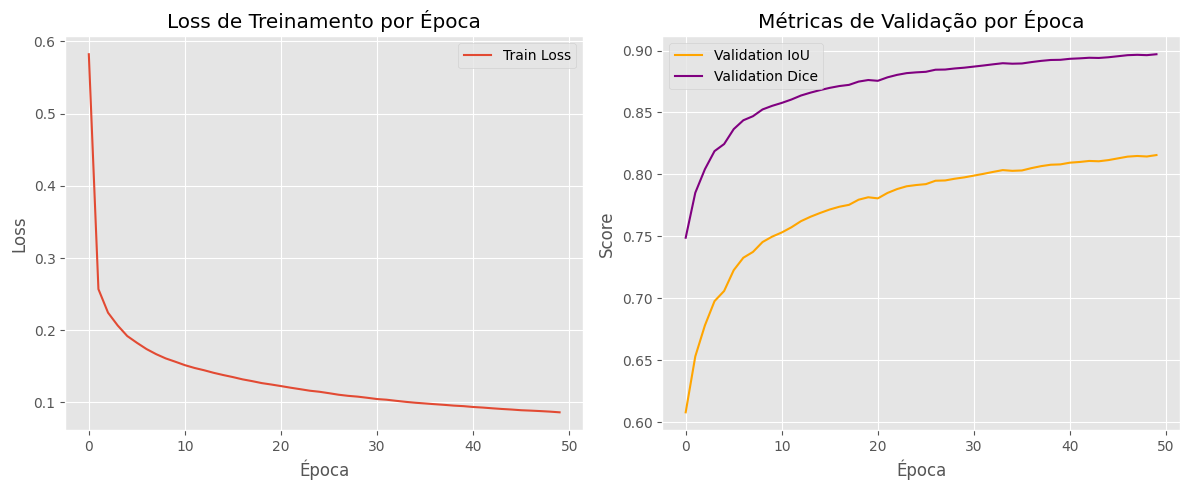


--- Visualizando Predições ---


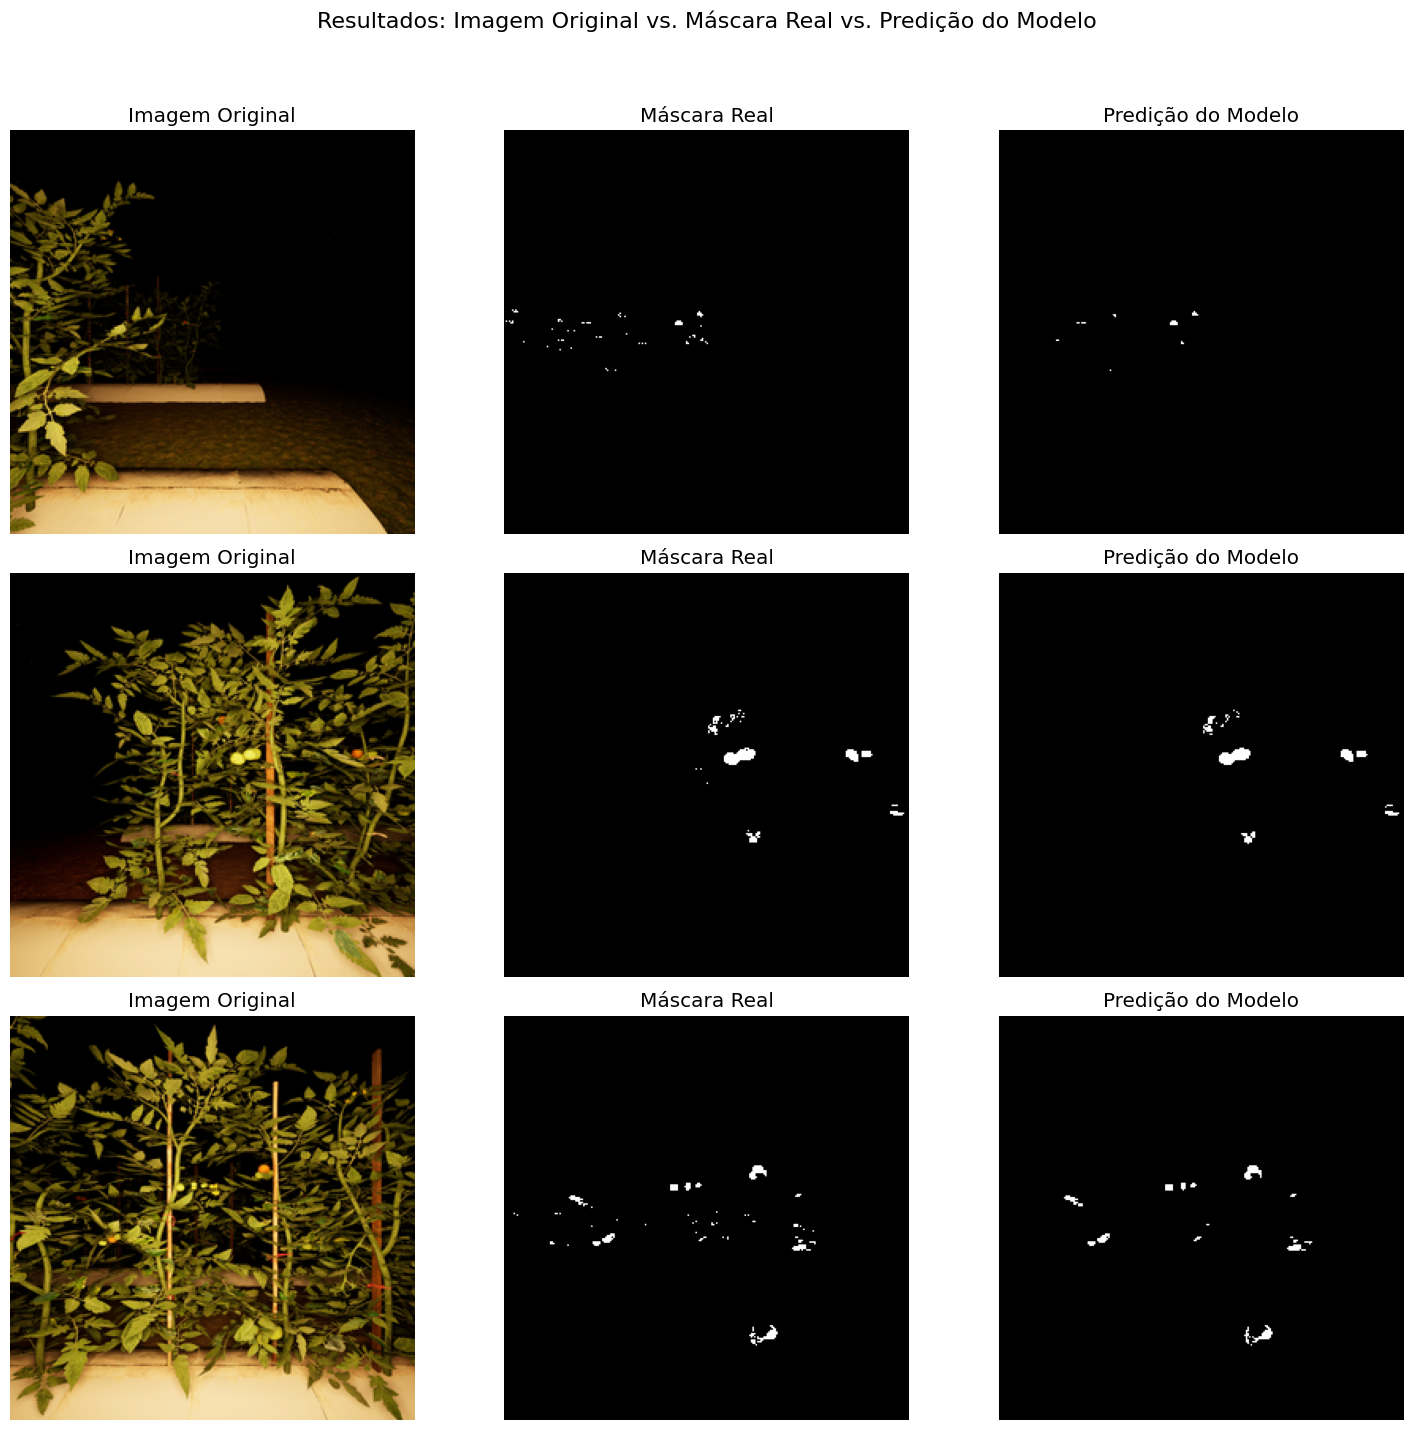

In [34]:
# Plotar gráficos de treinamento para o artigo
plt.style.use("ggplot")
plt.figure(figsize=(12, 5))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.title("Loss de Treinamento por Época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()

# Gráfico de Métricas de Validação
plt.subplot(1, 2, 2)
plt.plot(history['val_iou'], label='Validation IoU', color='orange')
plt.plot(history['val_dice'], label='Validation Dice', color='purple')
plt.title("Métricas de Validação por Época")
plt.xlabel("Época")
plt.ylabel("Score")
plt.legend()

plt.tight_layout()
plt.show()

# Visualizar predições no conjunto de validação
print("\n--- Visualizando Predições ---")

# Carregar o melhor modelo salvo
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.to(DEVICE)
model.eval()

# Pegar algumas imagens de validação
num_samples_to_show = 3
val_images, val_masks = next(iter(val_loader))

fig, axs = plt.subplots(num_samples_to_show, 3, figsize=(15, 15))
fig.suptitle('Resultados: Imagem Original vs. Máscara Real vs. Predição do Modelo', fontsize=16)


# Desnormalizar imagem para visualização
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

for i in range(num_samples_to_show):
    image = val_images[i].to(DEVICE)
    true_mask = val_masks[i].squeeze().cpu().numpy()

    with torch.no_grad():
        pred_mask = model(image.unsqueeze(0))
        pred_mask = torch.sigmoid(pred_mask)
        pred_mask = (pred_mask > 0.5).float().squeeze().cpu().numpy()

    image_display = inv_normalize(image).cpu().permute(1, 2, 0).numpy()

    # Imagem Original
    axs[i, 0].imshow(image_display)
    axs[i, 0].set_title("Imagem Original")
    axs[i, 0].axis('off')

    # Máscara Real (Ground Truth)
    axs[i, 1].imshow(true_mask, cmap='gray')
    axs[i, 1].set_title("Máscara Real")
    axs[i, 1].axis('off')

    # Predição do Modelo
    axs[i, 2].imshow(pred_mask, cmap='gray')
    axs[i, 2].set_title("Predição do Modelo")
    axs[i, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()